In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, MBartForConditionalGeneration, \
    MT5ForConditionalGeneration
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import paper_cka
import transformers

transformers.logging.set_verbosity_error()
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import inspect, re


def varname(p) -> str:
    for line in inspect.getframeinfo(inspect.currentframe().f_back)[3]:
        m = re.search(r'\bvarname\s*\(\s*([A-Za-z_][A-Za-z0-9_]*)\s*\)', line)
        if m:
            return str(m.group(1))

In [3]:
import gc


class ClearCache:

    def __enter__(self):
        gc.collect()
        torch.cuda.empty_cache()

    def __exit__(self, exc_type, exc_val, exc_tb):
        gc.collect()
        torch.cuda.empty_cache()

In [4]:
from typing import List, Dict, Any

PREFIX_TASK = {'en': "English", 'fr': "French", 'de': "German", 'es': "Spanish"}


def tokenize(examples: List[Dict[str, str]], **kwargs):
    tokenizer = kwargs['tokenizer']
    src_lang: str = kwargs['lang1']
    tgt_lang: str = kwargs['lang2']
    if "task" in kwargs:
        task: str = kwargs['task']
        batch_src: List[str] = [task + e[src_lang] for e in examples]
    else:
        batch_src: List[str] = [e[src_lang] for e in examples]
    batch_tgt: List[str] = [e[tgt_lang] for e in examples]
    # tokenize the batch of sentences
    outputs = tokenizer(batch_src, text_target=batch_tgt, return_special_tokens_mask=False,
                        add_special_tokens=True, truncation=True,
                        max_length=128, padding='max_length',
                        return_attention_mask=False, return_tensors='pt')
    # labels = tokenizer(batch_tgt, truncation=False)
    # batch_tgt = tokenizer.batch_decode(labels['input_ids'], skip_special_tokens=True)

    return {'input_ids': outputs['input_ids'], 'labels': outputs['labels']}

In [5]:
from torch.utils.data import DataLoader
from datasets import Dataset


def create_dataloader(trans_pair_ds: Dataset, input_column: str, fn_kwargs: Dict[str, Any],
                      batch_size: int) -> DataLoader:
    trans_pair_ds = trans_pair_ds.map(tokenize, batched=True, input_columns=[input_column],
                                      fn_kwargs=fn_kwargs)
    # trans_pair_ds = trans_pair_ds.remove_columns(column_names=['translation', 'original_text'])
    trans_pair_ds = trans_pair_ds.with_format('torch', columns=["input_ids", "labels"], output_all_columns=False)

    # ids = [e['input_ids'].view(1, -1) for e in iter(trans_pair_ds)]
    test_loader = DataLoader(trans_pair_ds, num_workers=2, batch_size=batch_size, drop_last=True, pin_memory=False)
    return test_loader


<frozen importlib._bootstrap>:219: RuntimeWarning: pyarrow._fs.FileInfo size changed, may indicate binary incompatibility. Expected 64 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: pyarrow._fs.FileSelector size changed, may indicate binary incompatibility. Expected 48 from C header, got 72 from PyObject


# mBART

In [6]:
from tqdm import tqdm
from typing import List, Union, Dict

checkpoints_dir = "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-fr-Mf1_weights_anlsys/"
directories = os.listdir(checkpoints_dir)
list_models: Dict[str, Union[MBartForConditionalGeneration, MT5ForConditionalGeneration]] = {}
print(f"Loading these models: {directories}")
for i, chckpnt in enumerate(tqdm(directories)):
    if chckpnt.startswith("checkpoint"):
        model_dir = os.path.join(checkpoints_dir, chckpnt)
        list_models[chckpnt] = AutoModelForSeq2SeqLM.from_pretrained(os.path.abspath(model_dir), output_attentions=True)
step_ft_models = list(list_models.values())

Loading these models: ['checkpoint-5000', 'checkpoint-10000', 'checkpoint-15000', 'checkpoint-20000', 'checkpoint-25000', 'checkpoint-30000', 'checkpoint-35000', 'checkpoint-40000', 'checkpoint-45000', 'checkpoint-50000', 'checkpoint-55000', 'checkpoint-60000', 'checkpoint-65000', 'checkpoint-70000', 'checkpoint-75000', 'checkpoint-80000', 'checkpoint-85000', 'checkpoint-90000', 'checkpoint-95000', 'checkpoint-100000']


100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


In [7]:
from transformers import MBartConfig

mbart_tok = AutoTokenizer.from_pretrained("nikodallanoce/mbart-cc4-vanilla-32k-5", src_lang="en_XX", tgt_lang="fr_XX")
mbart_config = MBartConfig(encoder_layers=6, decoder_layers=6,
                           encoder_ffn_dim=2048, decoder_ffn_dim=2048,
                           encoder_attention_heads=8, decoder_attention_heads=8,
                           d_model=512, max_length=128, vocab_size=mbart_tok.vocab_size, dropout=0.1)
random_model: MBartForConditionalGeneration = MBartForConditionalGeneration(mbart_config)

only_ft_en_fr: Union[
    MBartForConditionalGeneration, MT5ForConditionalGeneration] = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-fr-Mf1_ft_only/checkpoint-100000",
    output_attentions=True)

last_ft_model = list(list_models.values())[-1]

m1_model = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/S2_mbart_pre_en-fr(M1)/checkpoint-180000", output_attentions=True)
m2_model = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/S2_mbart_pre_en-fr_de(M2)/checkpoint-180000", output_attentions=True)
m2_model_rply = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/S2_mbart_pre_en-fr_de(M2)_replay_8/checkpoint-180000",
    output_attentions=True)
m3_model = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/S2_mbart_pre_en-fr_de_es(M3)/checkpoint-180000",
    output_attentions=True)
m3_model_rply = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/S2_mbart_pre_en-fr_de_es(M3)_replay_8/checkpoint-180000",
    output_attentions=True)
de_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_pre_en-de/checkpoint-180000", output_attentions=True)

# mf1_2_rply_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_pre_de_ft_en-fr(Mf1-2)_replay_8/checkpoint-100000",
#     output_attentions=True)

# mf1_2_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_pre_de_ft_en-fr(Mf1-2)/checkpoint-100000",
#     output_attentions=True)

mf1_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-fr-Mf1_weights_anlsys/checkpoint-100000",
    output_attentions=True)

mf2_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-de-Mf2/checkpoint-100000",
    output_attentions=True)

mf2_model_rply: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-de-Mf2_replay_8/checkpoint-100000",
    output_attentions=True)

mf23_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_pre_es_ft_en-de(Mf2-3)/checkpoint-80000",
    output_attentions=True)
mf23_model_rply: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_pre_es_ft_en-de(Mf2-3)_replay_8/checkpoint-95000",
    output_attentions=True)
mf13_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_pre_es_ft_en-fr(Mf3-1)/checkpoint-85000",
    output_attentions=True)
mf13_model_rply: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_pre_es_ft_en-fr(Mf3-1)_replay_8/checkpoint-100000",
    output_attentions=True)

only_ft_en_de: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-de_ft_only/checkpoint-100000",
    output_attentions=True)

mf3_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-es/checkpoint-100000",
    output_attentions=True)

mf3_model_rply: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-es_replay_8/checkpoint-100000",
    output_attentions=True)

col_names = ['(m1, m2)', '(m2, m3)', '(m1, m3)', '(m2, de)', '(m2, rnd)']

In [14]:
from datasets import load_dataset
from torch.utils.data import DataLoader

# wmt14_test = load_dataset("wmt14", "fr-en",
#                           cache_dir="/data/n.dallanoce/wmt14",
#                           split=f"test",
#                           verification_mode='no_checks')
# 
# cc_test = load_dataset("yhavinga/ccmatrix", "en-fr",
#                        cache_dir="/data/n.dallanoce/cc_en_fr",
#                        split=f"train[0:512]",
#                        verification_mode='no_checks')
fn_kwargs = {'tokenizer': mbart_tok, 'lang1': "de", 'lang2': "en"}

lang_2 = fn_kwargs['lang1'] if fn_kwargs['lang1']!="en" else fn_kwargs['lang2']
wmt14_val = load_dataset("wmt14", f"{lang_2}-en",
                         cache_dir="/data/n.dallanoce/wmt14",
                         split=f"validation[:128]",
                         verification_mode='no_checks')
src_lang = fn_kwargs['lang1'] + "_XX" if fn_kwargs['lang1']!="de" else fn_kwargs['lang1'] + "_DE"
tgt_lang = fn_kwargs['lang2'] + "_XX" if fn_kwargs['lang2']!="de" else fn_kwargs['lang2'] + "_DE"
mbart_tok = AutoTokenizer.from_pretrained("nikodallanoce/mbart-cc4-vanilla-32k-5", src_lang=src_lang, tgt_lang=tgt_lang)

#dataloader_test = create_dataloader(wmt14_test, "translation", fn_kwargs, 32)
dataloader_val = create_dataloader(wmt14_val, "translation", fn_kwargs, 8)
#dataloader_cc = create_dataloader(cc_test, "translation", fn_kwargs, 32)

Found cached dataset wmt14 (/data/n.dallanoce/wmt14/wmt14/de-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

| Comparing features |: 100%|██████████| 16/16 [00:09<00:00,  1.75it/s]


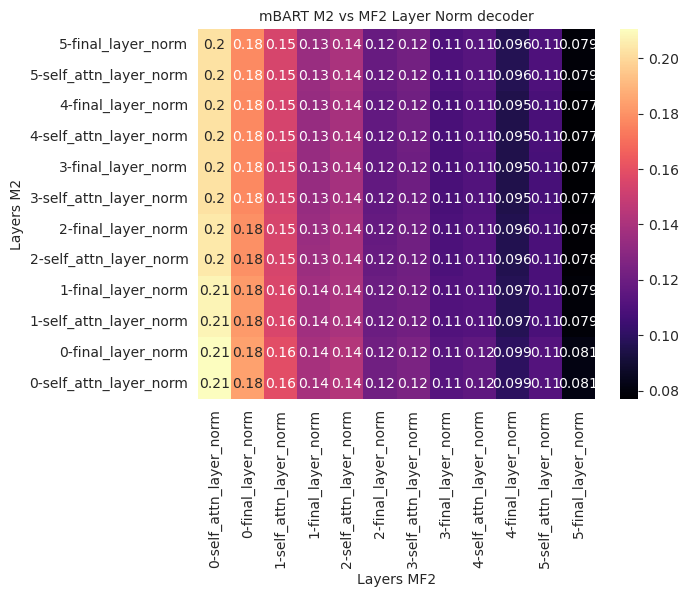

| Comparing features |: 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


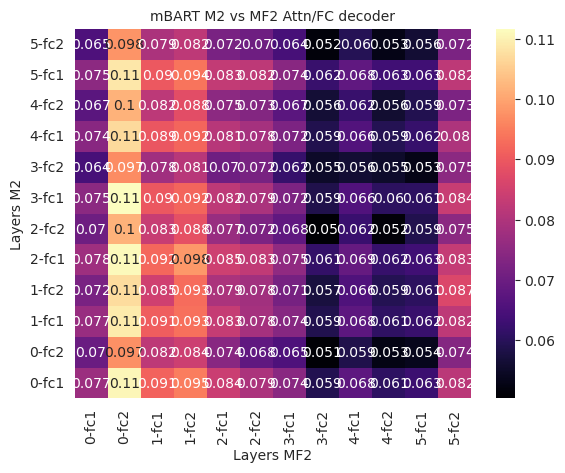

In [20]:
layers_enc_norm = [f"model.encoder.layers.{i}.self_attn_layer_norm" for i in range(6)] + [
    f"model.encoder.layers.{i}.final_layer_norm" for i in range(6)]
layers_enc_fc = [f"model.encoder.layers.{i}.fc1" for i in range(6)] + [f"model.encoder.layers.{i}.fc2" for i in
                                                                       range(6)]
layers_dec_fc = [f"model.decoder.layers.{i}.fc1" for i in range(6)] + [f"model.decoder.layers.{i}.fc2" for i in
                                                                       range(6)]
layers_dec_norm = [f"model.decoder.layers.{i}.self_attn_layer_norm" for i in range(6)] + [
    f"model.decoder.layers.{i}.final_layer_norm" for i in range(6)] + [f"model.decoder.layers.{i}.encoder_attn_layer_norm" for i in range(6)]
layers_enc_dec_norm = [f"model.decoder.layers.{i}.encoder_attn_layer_norm" for i in range(6)]
#layers = [f"model.encoder.layers.{i}.self_attn.out_proj" for i in range(6)]

type_of_comp_enc = {0: "Layer Norm", 1: "Attn/FC"}
for i, l_t in enumerate([layers_enc_norm, layers_enc_fc]):
    with ClearCache():
        with torch.no_grad():
            name1 = "M2"
            name2 = "MF2"
            cka = paper_cka.CKA(random_model, only_ft_en_de, name1, name2, model1_layers=l_t, model2_layers=l_t,
                                device="cuda:0")
            cka.compare(dataloader_val, debiased=True)
            #print(cka.sanity_check())
            cka.plot_results(show_ticks_labels=True, short_tick_labels_splits=2,
                             title=f"mBART {name1} vs {name2} {type_of_comp_enc[i]} decoder", save_path=None, show_annotations=True)
#print(cka.model1_info['Layers'])
#print(cka.export()["CKA"])
#print(m1_model)

In [11]:
all_lyrs = list(m1_model.named_modules())
all_lyrs

[('',
  MBartForConditionalGeneration(
    (model): MBartModel(
      (shared): Embedding(32030, 512, padding_idx=1)
      (encoder): MBartEncoder(
        (embed_tokens): Embedding(32030, 512, padding_idx=1)
        (embed_positions): MBartLearnedPositionalEmbedding(1026, 512)
        (layers): ModuleList(
          (0): MBartEncoderLayer(
            (self_attn): MBartAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          

In [53]:
m1_model.model.encoder.layers[0]

MBartEncoderLayer(
  (self_attn): MBartAttention(
    (k_proj): Linear(in_features=512, out_features=512, bias=True)
    (v_proj): Linear(in_features=512, out_features=512, bias=True)
    (q_proj): Linear(in_features=512, out_features=512, bias=True)
    (out_proj): Linear(in_features=512, out_features=512, bias=True)
  )
  (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (activation_fn): GELUActivation()
  (fc1): Linear(in_features=512, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)

# mT6

In [6]:
from transformers import MT5Config
from MT6 import MT6

mt6_m1 = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_pre_en-fr(M1)_10_10_20_tb/checkpoint-180000",
    output_attentions=True)

mt6_m2 = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_pre_en-fr_de(M2)_10_20_tb/checkpoint-180000", output_attentions=True)
mt6_m2_rply = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_pre_en-fr_de(M2)_10_20_tb_replay_8/checkpoint-180000",
    output_attentions=True)
mt6_m3 = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_pre_en-fr_de(M2)_10_20_tb/checkpoint-180000",
    output_attentions=True)
mt6_m3_rply = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_pre_en-fr_de(M2)_10_20_tb_replay_8/checkpoint-180000",
    output_attentions=True)

mt6_mf1_2_rply: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_pre_de_ft_en-fr(MF1-2)_10_20_tb_replay_8/checkpoint-100000",
    output_attentions=True)

mt6_mf1_2: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_pre_de_ft_en-fr(MF1-2)_10_20_tb/checkpoint-100000",
    output_attentions=True)

mt6_mf1: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_ft_en-fr(MF1)_10_10_20_s_tb/checkpoint-100000",
    output_attentions=True)

mt6_mf2: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_ft_en-de(MF2)_10_20_tb/checkpoint-100000",
    output_attentions=True)

mt6_mf2_rply: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_ft_en-de(MF2)_10_20_tb_replay_8/checkpoint-100000",
    output_attentions=True)

# mf23_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_pre_es_ft_en-de(Mf2-3)/checkpoint-80000",
#     output_attentions=True)
mt6_mf23_rply: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_pre_es_ft_en-de(MF2-3)_10_20_tb_replay_8/checkpoint-100000",
    output_attentions=True)
# mf13_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_pre_es_ft_en-fr(Mf3-1)/checkpoint-85000",
#     output_attentions=True)
mt6_mf13_rply: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_pre_es_ft_en-fr-MF3-1_10_20_tb_replay_8/checkpoint-100000",
    output_attentions=True)

# only_ft_en_de: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-de_ft_only/checkpoint-100000",
#     output_attentions=True)

# mf3_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mt",
#     output_attentions=True)

mf3_model_rply: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_ft_en-es(MF3)_10_20_tb_replay_8/checkpoint-100000",
    output_attentions=True)
mt6_tok = AutoTokenizer.from_pretrained("nikodallanoce/mt5-cc4-vanilla-32k-5")
mt6_rnd = MT5ForConditionalGeneration(
        MT5Config(num_layers=6, d_model=512, num_heads=8, d_ff=2048, vocab_size=len(mt6_tok), max_length=128, tie_word_embeddings=True))

In [18]:
from datasets import load_dataset
from torch.utils.data import DataLoader

# wmt14_test = load_dataset("wmt14", "fr-en",
#                           cache_dir="/data/n.dallanoce/wmt14",
#                           split=f"test",
#                           verification_mode='no_checks')
# 
# cc_test = load_dataset("yhavinga/ccmatrix", "en-fr",
#                        cache_dir="/data/n.dallanoce/cc_en_fr",
#                        split=f"train[0:512]",
#                        verification_mode='no_checks')

wmt14_val = load_dataset("wmt14", "de-en",
                         cache_dir="/data/n.dallanoce/wmt14",
                         split=f"validation[0:128]",
                         verification_mode='no_checks')

fn_kwargs = {'tokenizer': mt6_tok, 'lang1': "en", 'lang2': "de"}
#dataloader_test = create_dataloader(wmt14_test, "translation", fn_kwargs, 32)
dataloader_val = create_dataloader(wmt14_val, "translation", fn_kwargs, 8)
#dataloader_cc = create_dataloader(cc_test, "translation", fn_kwargs, 32)

Found cached dataset wmt14 (/data/n.dallanoce/wmt14/wmt14/de-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)
Loading cached processed dataset at /data/n.dallanoce/wmt14/wmt14/de-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4/cache-8e9c1a137c793a7b.arrow


In [19]:
all_lyrs = list(mt6_m1.named_modules())
all_lyrs

[('',
  MT5ForConditionalGeneration(
    (shared): Embedding(32103, 512)
    (encoder): MT5Stack(
      (embed_tokens): Embedding(32103, 512)
      (block): ModuleList(
        (0): MT5Block(
          (layer): ModuleList(
            (0): MT5LayerSelfAttention(
              (SelfAttention): MT5Attention(
                (q): Linear(in_features=512, out_features=512, bias=False)
                (k): Linear(in_features=512, out_features=512, bias=False)
                (v): Linear(in_features=512, out_features=512, bias=False)
                (o): Linear(in_features=512, out_features=512, bias=False)
                (relative_attention_bias): Embedding(32, 8)
              )
              (layer_norm): MT5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): MT5LayerFF(
              (DenseReluDense): MT5DenseGatedActDense(
                (wi_0): Linear(in_features=512, out_features=2048, bias=False)
                (wi_1): Linear(in_feature

In [62]:
mt6_m1.decoder.block[0]

MT5Block(
  (layer): ModuleList(
    (0): MT5LayerSelfAttention(
      (SelfAttention): MT5Attention(
        (q): Linear(in_features=512, out_features=512, bias=False)
        (k): Linear(in_features=512, out_features=512, bias=False)
        (v): Linear(in_features=512, out_features=512, bias=False)
        (o): Linear(in_features=512, out_features=512, bias=False)
        (relative_attention_bias): Embedding(32, 8)
      )
      (layer_norm): MT5LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): MT5LayerCrossAttention(
      (EncDecAttention): MT5Attention(
        (q): Linear(in_features=512, out_features=512, bias=False)
        (k): Linear(in_features=512, out_features=512, bias=False)
        (v): Linear(in_features=512, out_features=512, bias=False)
        (o): Linear(in_features=512, out_features=512, bias=False)
      )
      (layer_norm): MT5LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (2): MT5LayerFF(
      (DenseReluDense): M

In [11]:
mt6_m1.encoder.block[0].layer[1]

MT5LayerFF(
  (DenseReluDense): MT5DenseGatedActDense(
    (wi_0): Linear(in_features=512, out_features=2048, bias=False)
    (wi_1): Linear(in_features=512, out_features=2048, bias=False)
    (wo): Linear(in_features=2048, out_features=512, bias=False)
    (dropout): Dropout(p=0.1, inplace=False)
    (act): NewGELUActivation()
  )
  (layer_norm): MT5LayerNorm()
  (dropout): Dropout(p=0.1, inplace=False)
)

| Comparing features |: 100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


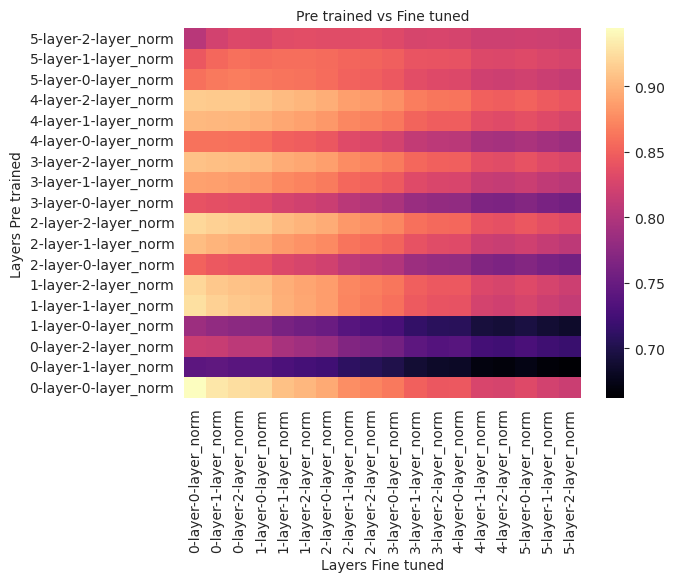

| Comparing features |: 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]


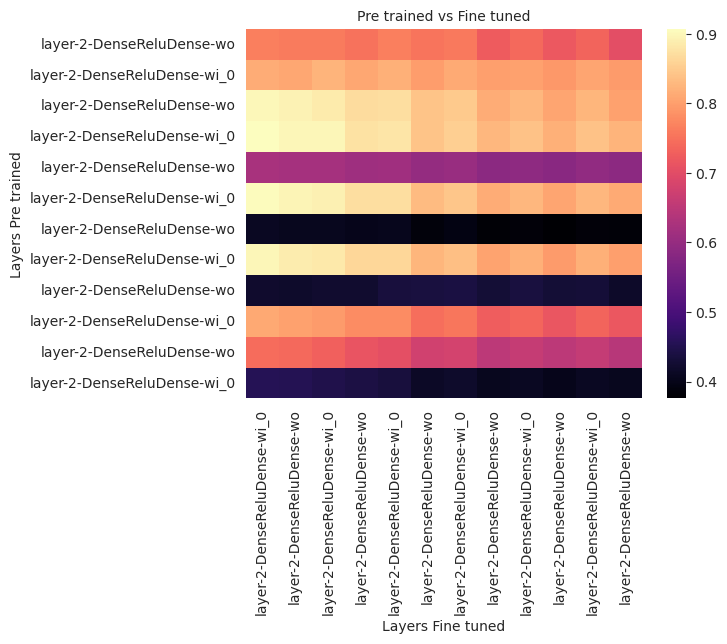

In [19]:
num_layers = 6
layers_norm_enc = [f"encoder.block.{i}.layer.0.layer_norm" for i in range(num_layers)] + [
    f"encoder.block.{i}.layer.1.layer_norm" for i in range(num_layers)]
layers_fc_enc = [f"encoder.block.{i}.layer.1.DenseReluDense.wi_0" for i in range(num_layers)] + [
    f"encoder.block.{i}.layer.1.DenseReluDense.wo" for i in range(num_layers)] #+ [f"encoder.block.{i}.layer.1.DenseReluDense.wi_1" for i in range(num_layers)]
layers_norm_dec = [f"decoder.block.{i}.layer.0.layer_norm" for i in range(num_layers)] + [
    f"decoder.block.{i}.layer.1.layer_norm" for i in range(num_layers)] + [f"decoder.block.{i}.layer.2.layer_norm" for i in range(num_layers)]
layers_fc_dec = [f"decoder.block.{i}.layer.2.DenseReluDense.wi_0" for i in range(num_layers)] + [
    f"decoder.block.{i}.layer.2.DenseReluDense.wo" for i in range(num_layers)]
#layers = [f"model.encoder.layers.{i}.self_attn.out_proj" for i in range(6)]
for l_t in [layers_norm_dec, layers_fc_dec]:
    with ClearCache():
        with torch.no_grad():
            cka = paper_cka.CKA(mt6_mf1, mt6_rnd, "Pre trained", "Fine tuned", model1_layers=l_t,
                                model2_layers=l_t, device="cuda:0")
            cka.compare(dataloader_val, debiased=True)
            #print(cka.sanity_check())
            cka.plot_results(show_ticks_labels=True, short_tick_labels_splits=4, show_annotations=False)